# Crypto_Bot Tutorial


First we download the module yfinance that gets data from Yahoo Finance

In [4]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



Import the necessary modules.

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

Download the information of of the BTC/USD chart

In [6]:
BTC_USD = yf.download("BTC-USD", start='2021-01-01', end='2022-11-01', interval="1d")

[*********************100%***********************]  1 of 1 completed


In [7]:
BTC_USD.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


## Create a price chart

Here we create a price chart for the data in the dataframe.

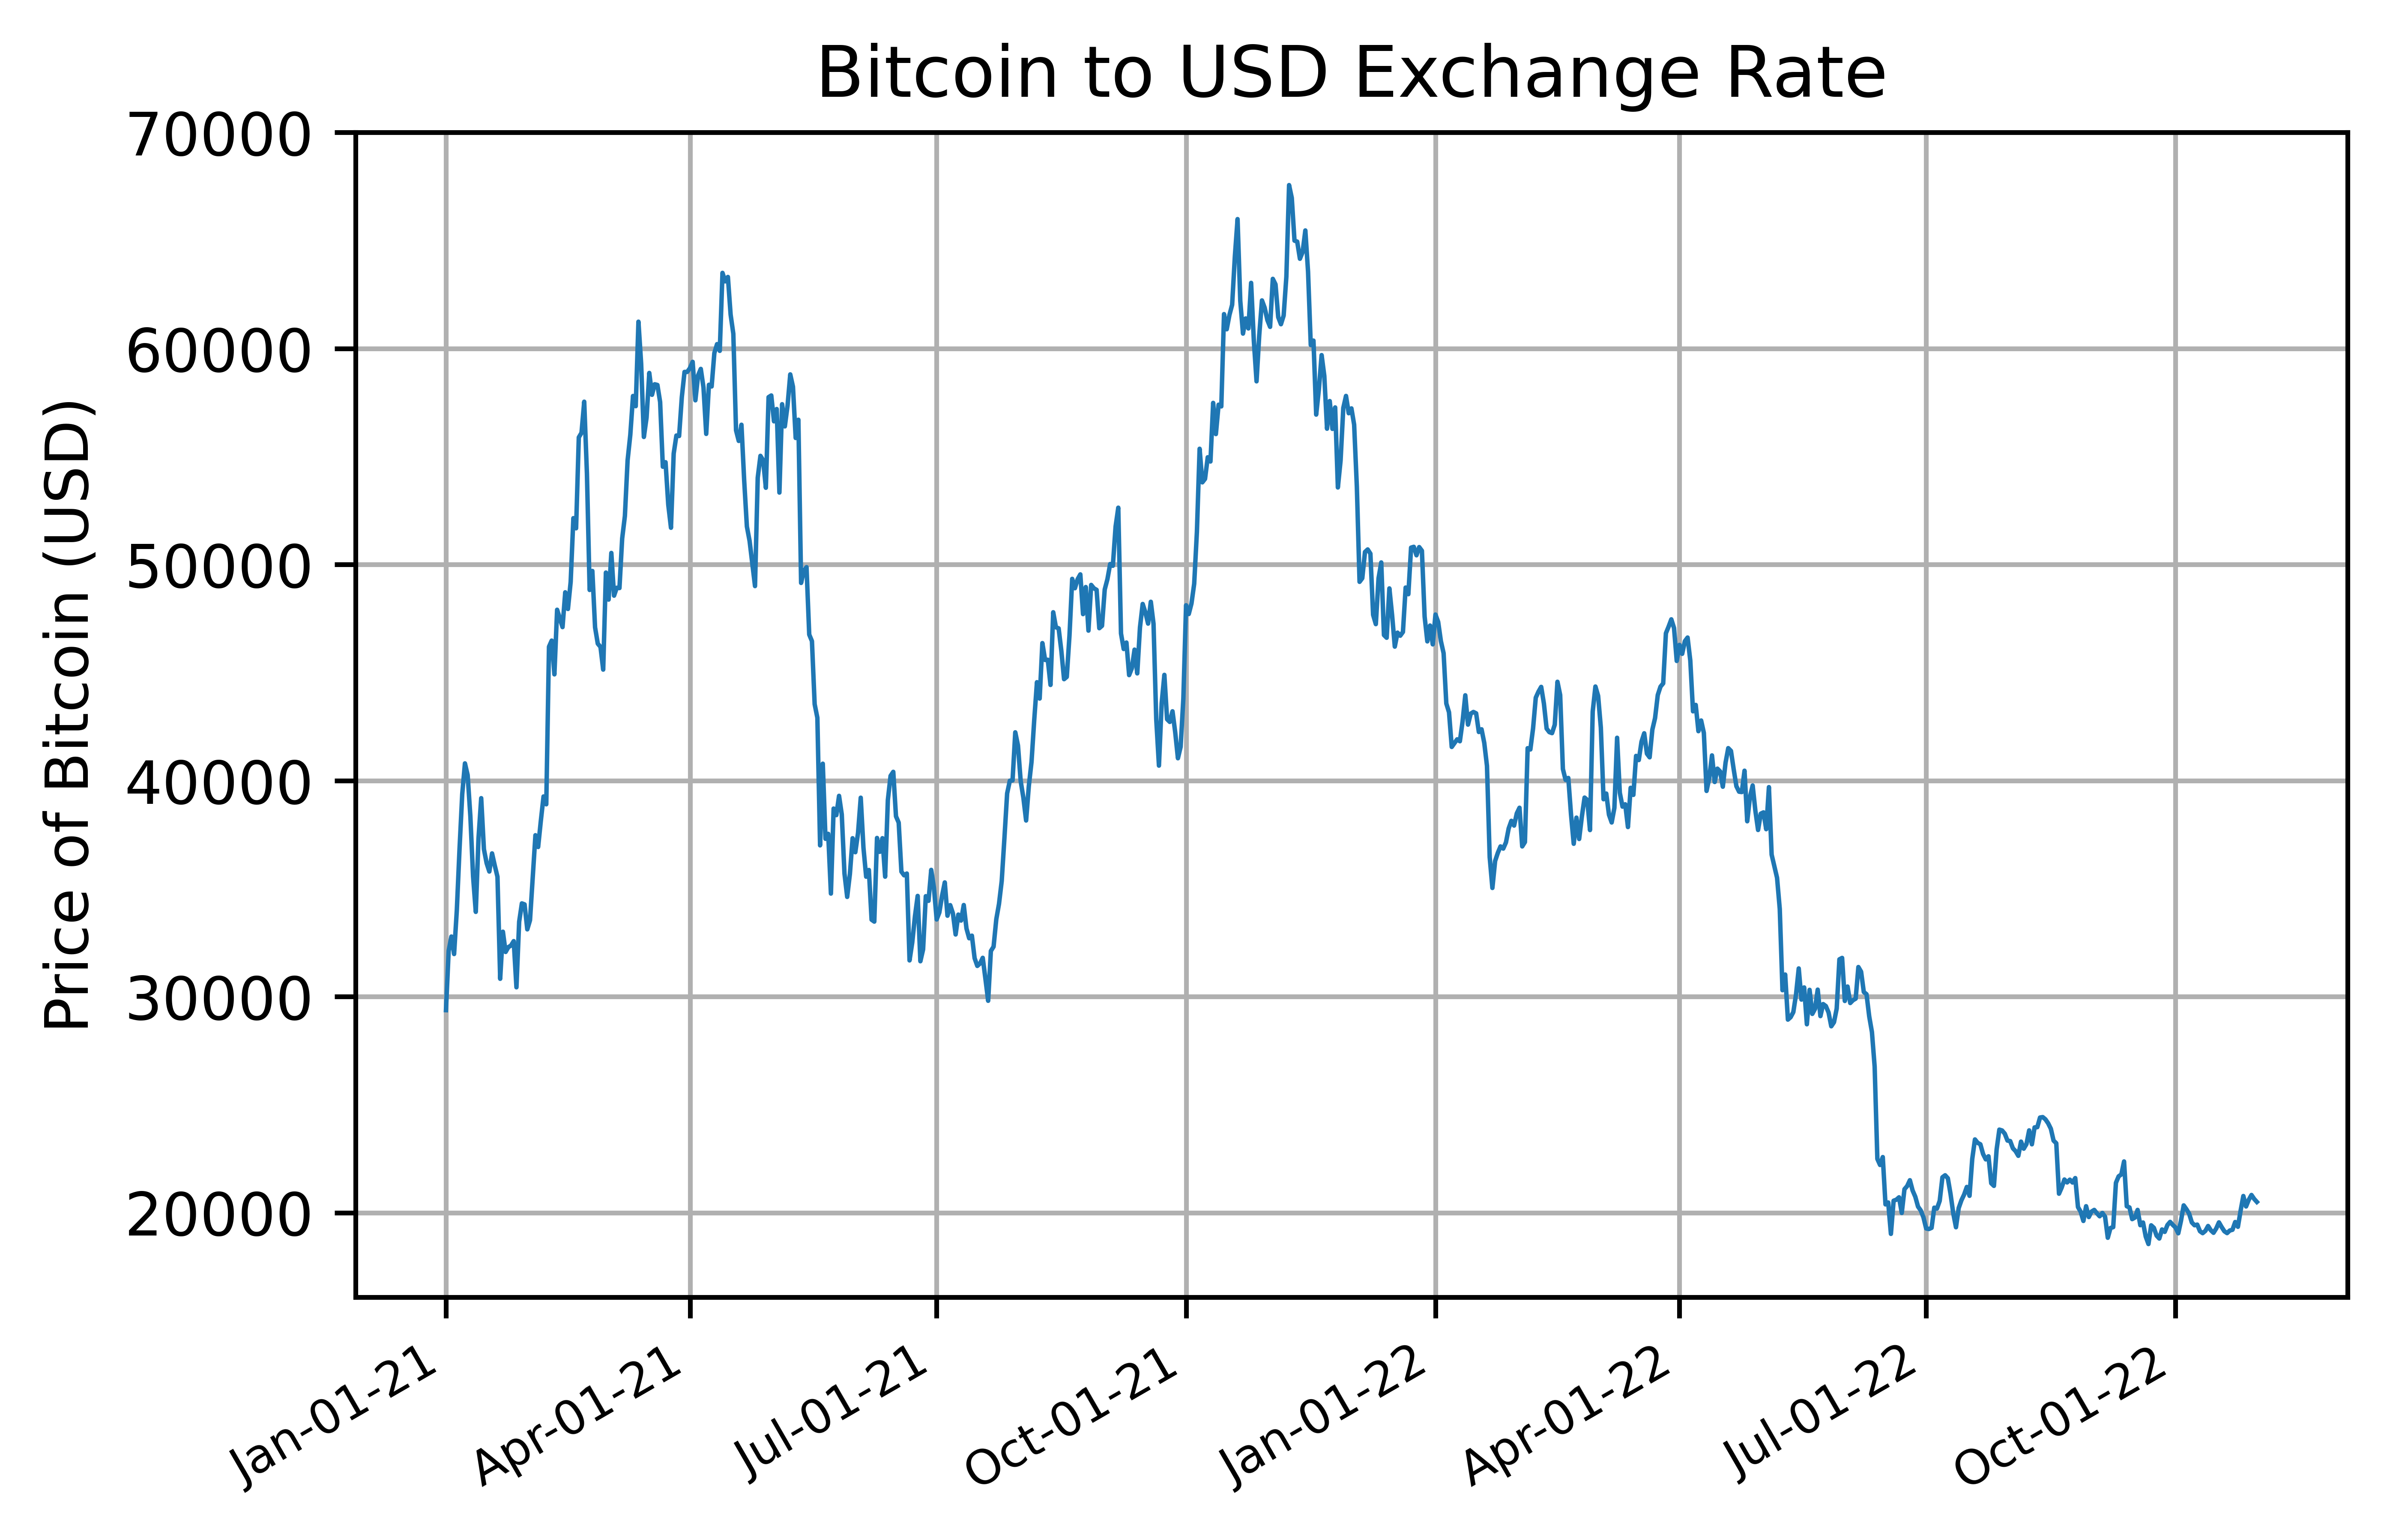

In [8]:
fig, ax = plt.subplots(dpi=1000) #figure and axes

# formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis="x", labelsize=8)
fig.autofmt_xdate()

# date vs closing price plot (1 day interval)
ax.plot(BTC_USD["Close"], lw=0.75)

# add labels and title
ax.set_ylabel("Price of Bitcoin (USD)")
ax.set_title("Bitcoin to USD Exchange Rate")
ax.grid() # add a grid

# display plot
plt.show()




### Compute  simple moving averages

Here we compute simple moving averages for 9 days and 30 days.

In [9]:
# Compute a 9-day simple moving average with pandas
BTC_USD["SMA_9"] = BTC_USD["Close"].rolling(window=9, min_periods=1).mean()

# compute a 30-day moving average
BTC_USD["SMA_30"] = BTC_USD["Close"].rolling(window=30, min_periods=1).mean()

In [10]:
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_30
Date,,,,,,,,
2022-10-27,20772.802734,20854.044922,20255.373047,20285.835938,20285.835938,49625110402,19626.516493,19501.755013
2022-10-28,20287.957031,20724.980469,20086.068359,20595.351562,20595.351562,43994715910,19788.273872,19540.709375
2022-10-29,20595.103516,20988.394531,20566.484375,20818.476562,20818.476562,40369840645,19984.355686,19582.223568
2022-10-30,20817.982422,20917.005859,20547.462891,20635.603516,20635.603516,31486345556,20146.926215,19622.350716
2022-10-31,20633.695312,20795.320312,20287.458984,20495.773438,20495.773438,45668466815,20289.991102,19661.806641


### Plot Simple Moving Averages

Here, we plot the simple moving averages against time

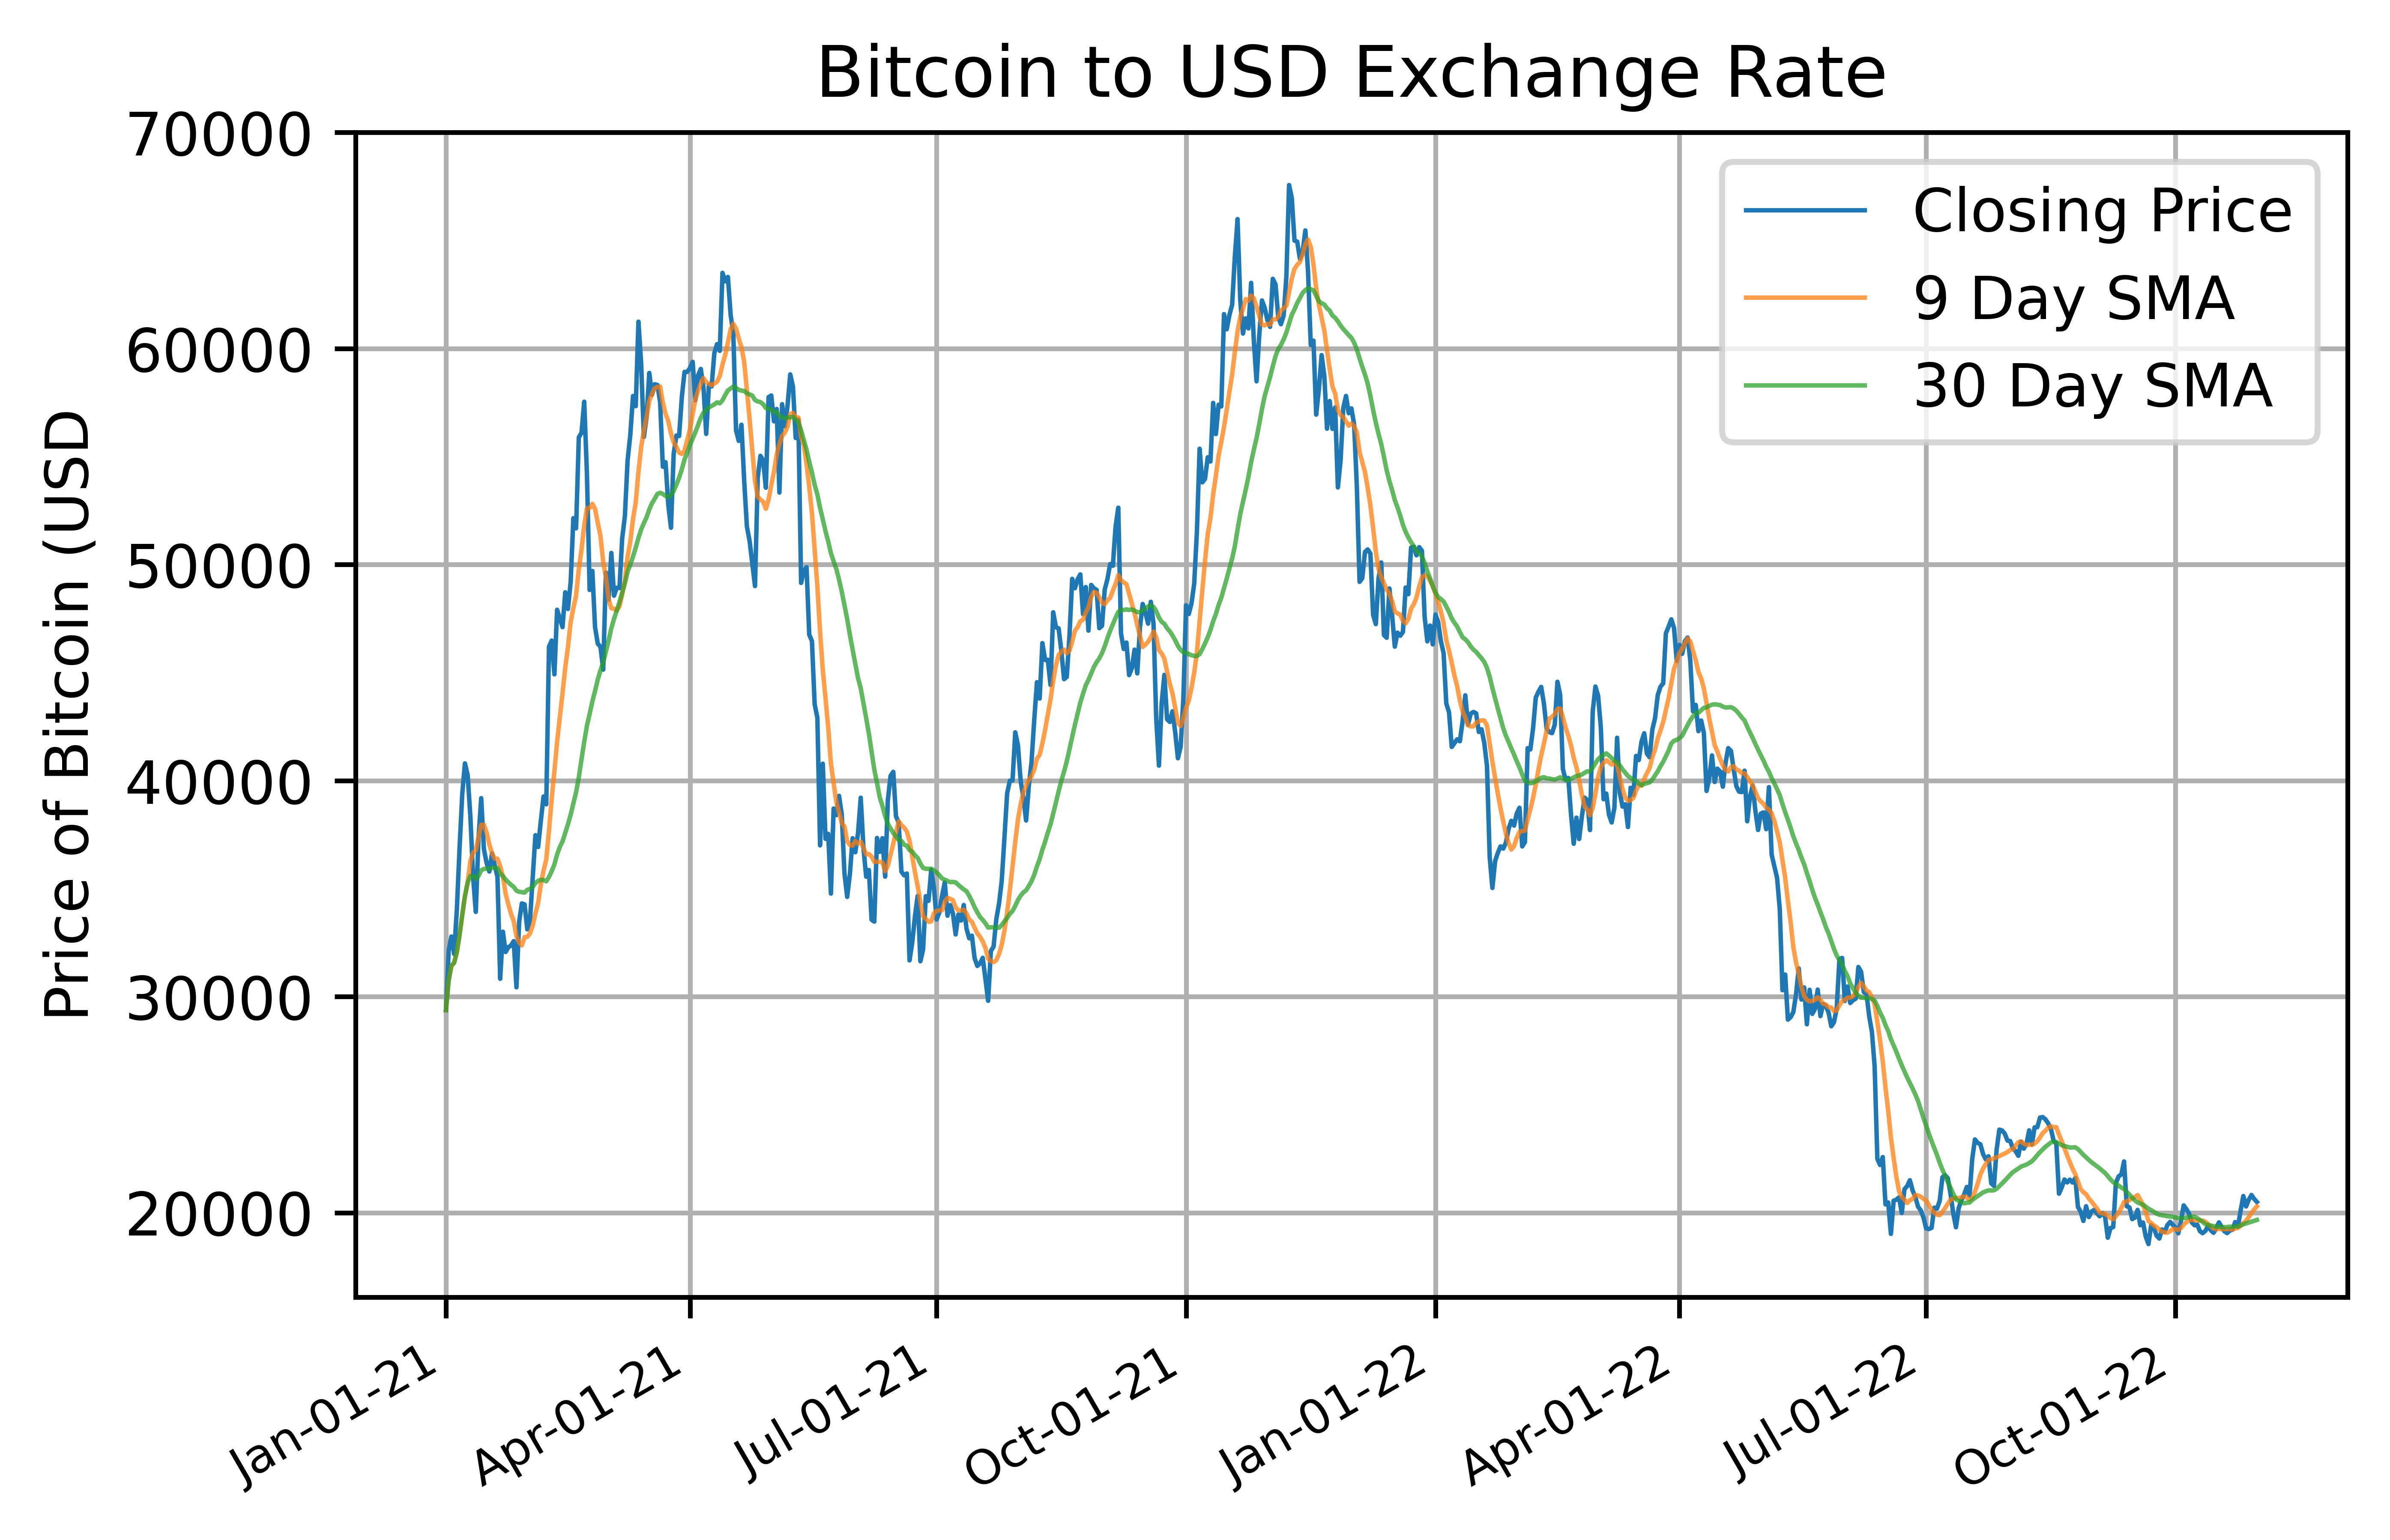

In [13]:
fig, ax = plt.subplots(dpi=1000)

# formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis="x", labelsize=8)
fig.autofmt_xdate()

# plot the closing price against the date (1 day interval)
ax.plot(BTC_USD["Close"], lw=0.75, label="Closing Price")

ax.plot(BTC_USD["SMA_9"], lw=0.75, alpha=0.75, label="9 Day SMA")
ax.plot(BTC_USD["SMA_30"], lw=0.75, alpha=0.75, label="30 Day SMA")

# Add labels and title to the plot
ax.set_ylabel("Price of Bitcoin (USD")
ax.set_title("Bitcoin to USD Exchange Rate")
ax.grid()       # add a grid
ax.legend() # add a legend

# display chart
plt.show()

Use the Moving Average Crossover to determine whether to buy or sell.

In [14]:
# create a pandas dataframe that is the same size as the BTC_USD dataframe and covers the same dates
trade_signals= pd.DataFrame(index=BTC_USD.index)

# define the intervals for the fast and slow MAs (in days)
short_interval = 10
long_interval = 40

# compute the simple MAs and add it to the dataframe as new columns
trade_signals["Short"] = BTC_USD["Close"].rolling(window=short_interval, min_periods=1).mean()
trade_signals["Long"] = BTC_USD["Close"].rolling(window=long_interval, min_periods=1).mean()

# create a new column called Signal
trade_signals["Signal"] = 0.0

# wherever the shorter SMA is above the longer SMA, set the signal column to 1, else 0
trade_signals["Signal"] = np.where(trade_signals["Short"] > trade_signals["Long"], 1.0, 0.0)

We want to buy when the short term SMA crosses the long term SMA, and sell when it crosses from above. For this, we use the `Signal` column in the `trade_signals` dataframe. If the `Signal` column has value of 0.0 on a given date and switches to 1.0, it means the short term SMA has crossed the long term SMA from below, indicating we should buy. If it goes from 1.0 to 0.0, then it is time to sell, because the short term was above the long termand then crossed over.

We will then create a new column called `Positions`, which will tell the algorithm to either buy or sell. A -1.0 is a sell order and a 0.0 is null. 1.0 will represent a buy order. We will use the `diff()` method for this.

In [15]:
trade_signals["Position"] = trade_signals["Signal"].diff()

Now we test the strategy

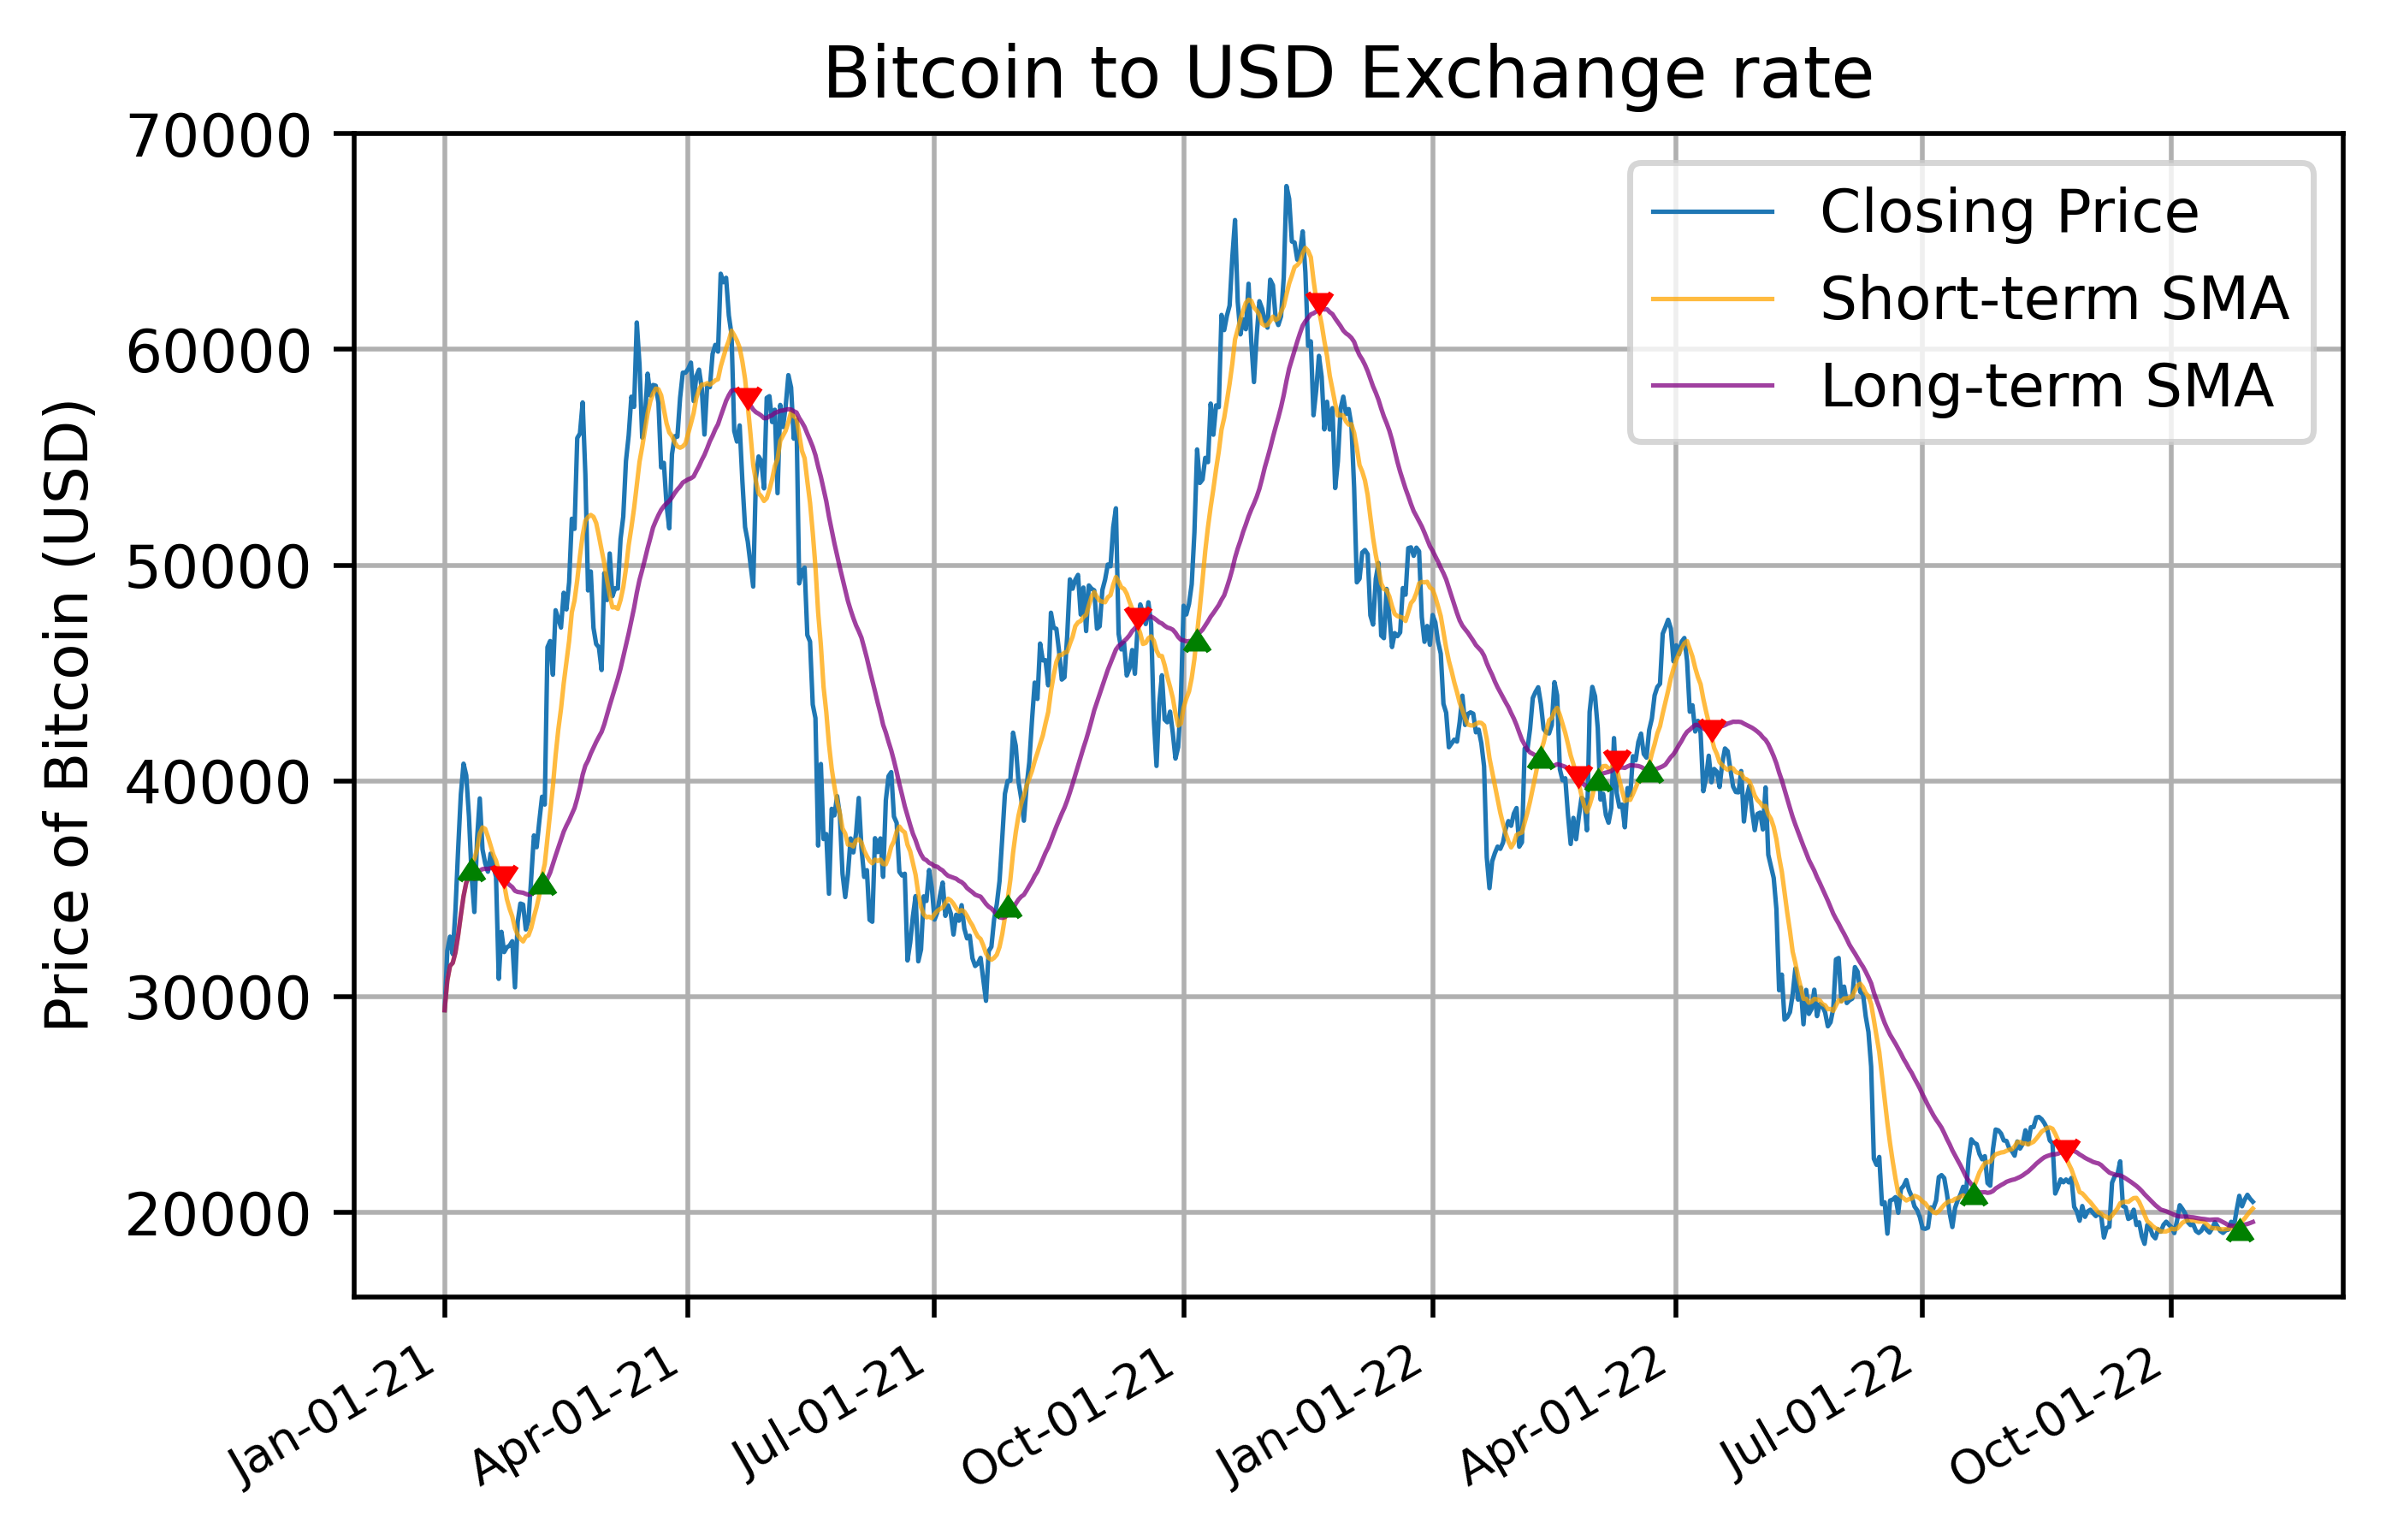

In [16]:
fig, ax = plt.subplots(dpi=500)

# format the dat axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis="x", labelsize=8)
fig.autofmt_xdate()

# plot the BTC closing price against the date (1 day)
ax.plot(BTC_USD["Close"], lw=0.75, label="Closing Price")

# plot the shorter term MA
ax.plot(trade_signals["Short"], lw=0.75, alpha=0.75, color="orange", label="Short-term SMA")

# plot the longer term MA
ax.plot(trade_signals["Long"], lw=0.75, alpha=0.75, color="purple", label="Long-term SMA")

# add green arrows for buy orders
ax.plot(trade_signals.loc[trade_signals["Position"] == 1.0].index, trade_signals.Short[trade_signals["Position"] == 1.0],
        marker=6, ms=4, linestyle="none", color="green")

# add red arrows to indicate sell orders
ax.plot(trade_signals.loc[trade_signals["Position"] == -1.0].index, trade_signals.Short[trade_signals["Position"] == -1.0],
        marker=7, ms=4, linestyle="none", color="red")

# add labels and title to the plot
ax.set_ylabel("Price of Bitcoin (USD)")
ax.set_title("Bitcoin to USD Exchange rate")
ax.grid()       # add a grid
ax.legend()     # add a legend

# display chart
plt.show()

### **Backtesting the Algorithm** 

In [18]:
# initial amount
initial_balance = 100000.00     # hundred thousand USD

# create a dataframe containing all considered dates
backtest = pd.DataFrame(index=trade_signals.index)

# add column containing daily % returns of BTC
backtest["BTC_Return"] = BTC_USD["Close"] / BTC_USD["Close"].shift(1)   # currnt closing price / yesterday's closing price

Now we compute the daily returns of the algorithm. We assume that the entire portfolio is all USD or BTC. Hence, portfolio value remains constant when holding USD and returns is daily return of BTC when portfolio is in BTC

In [19]:
# column with daily % return of Moving Average Crossover strategy
backtest["Alg_return"] = np.where(trade_signals.Signal == 1, backtest.BTC_Return, 1.0)

# column containing daily portfolio value
backtest["Balance"] = initial_balance * backtest.Alg_return.cumprod()   # cumulative product

Now we make a comparison using the alogorithm and a buy and hold strategy

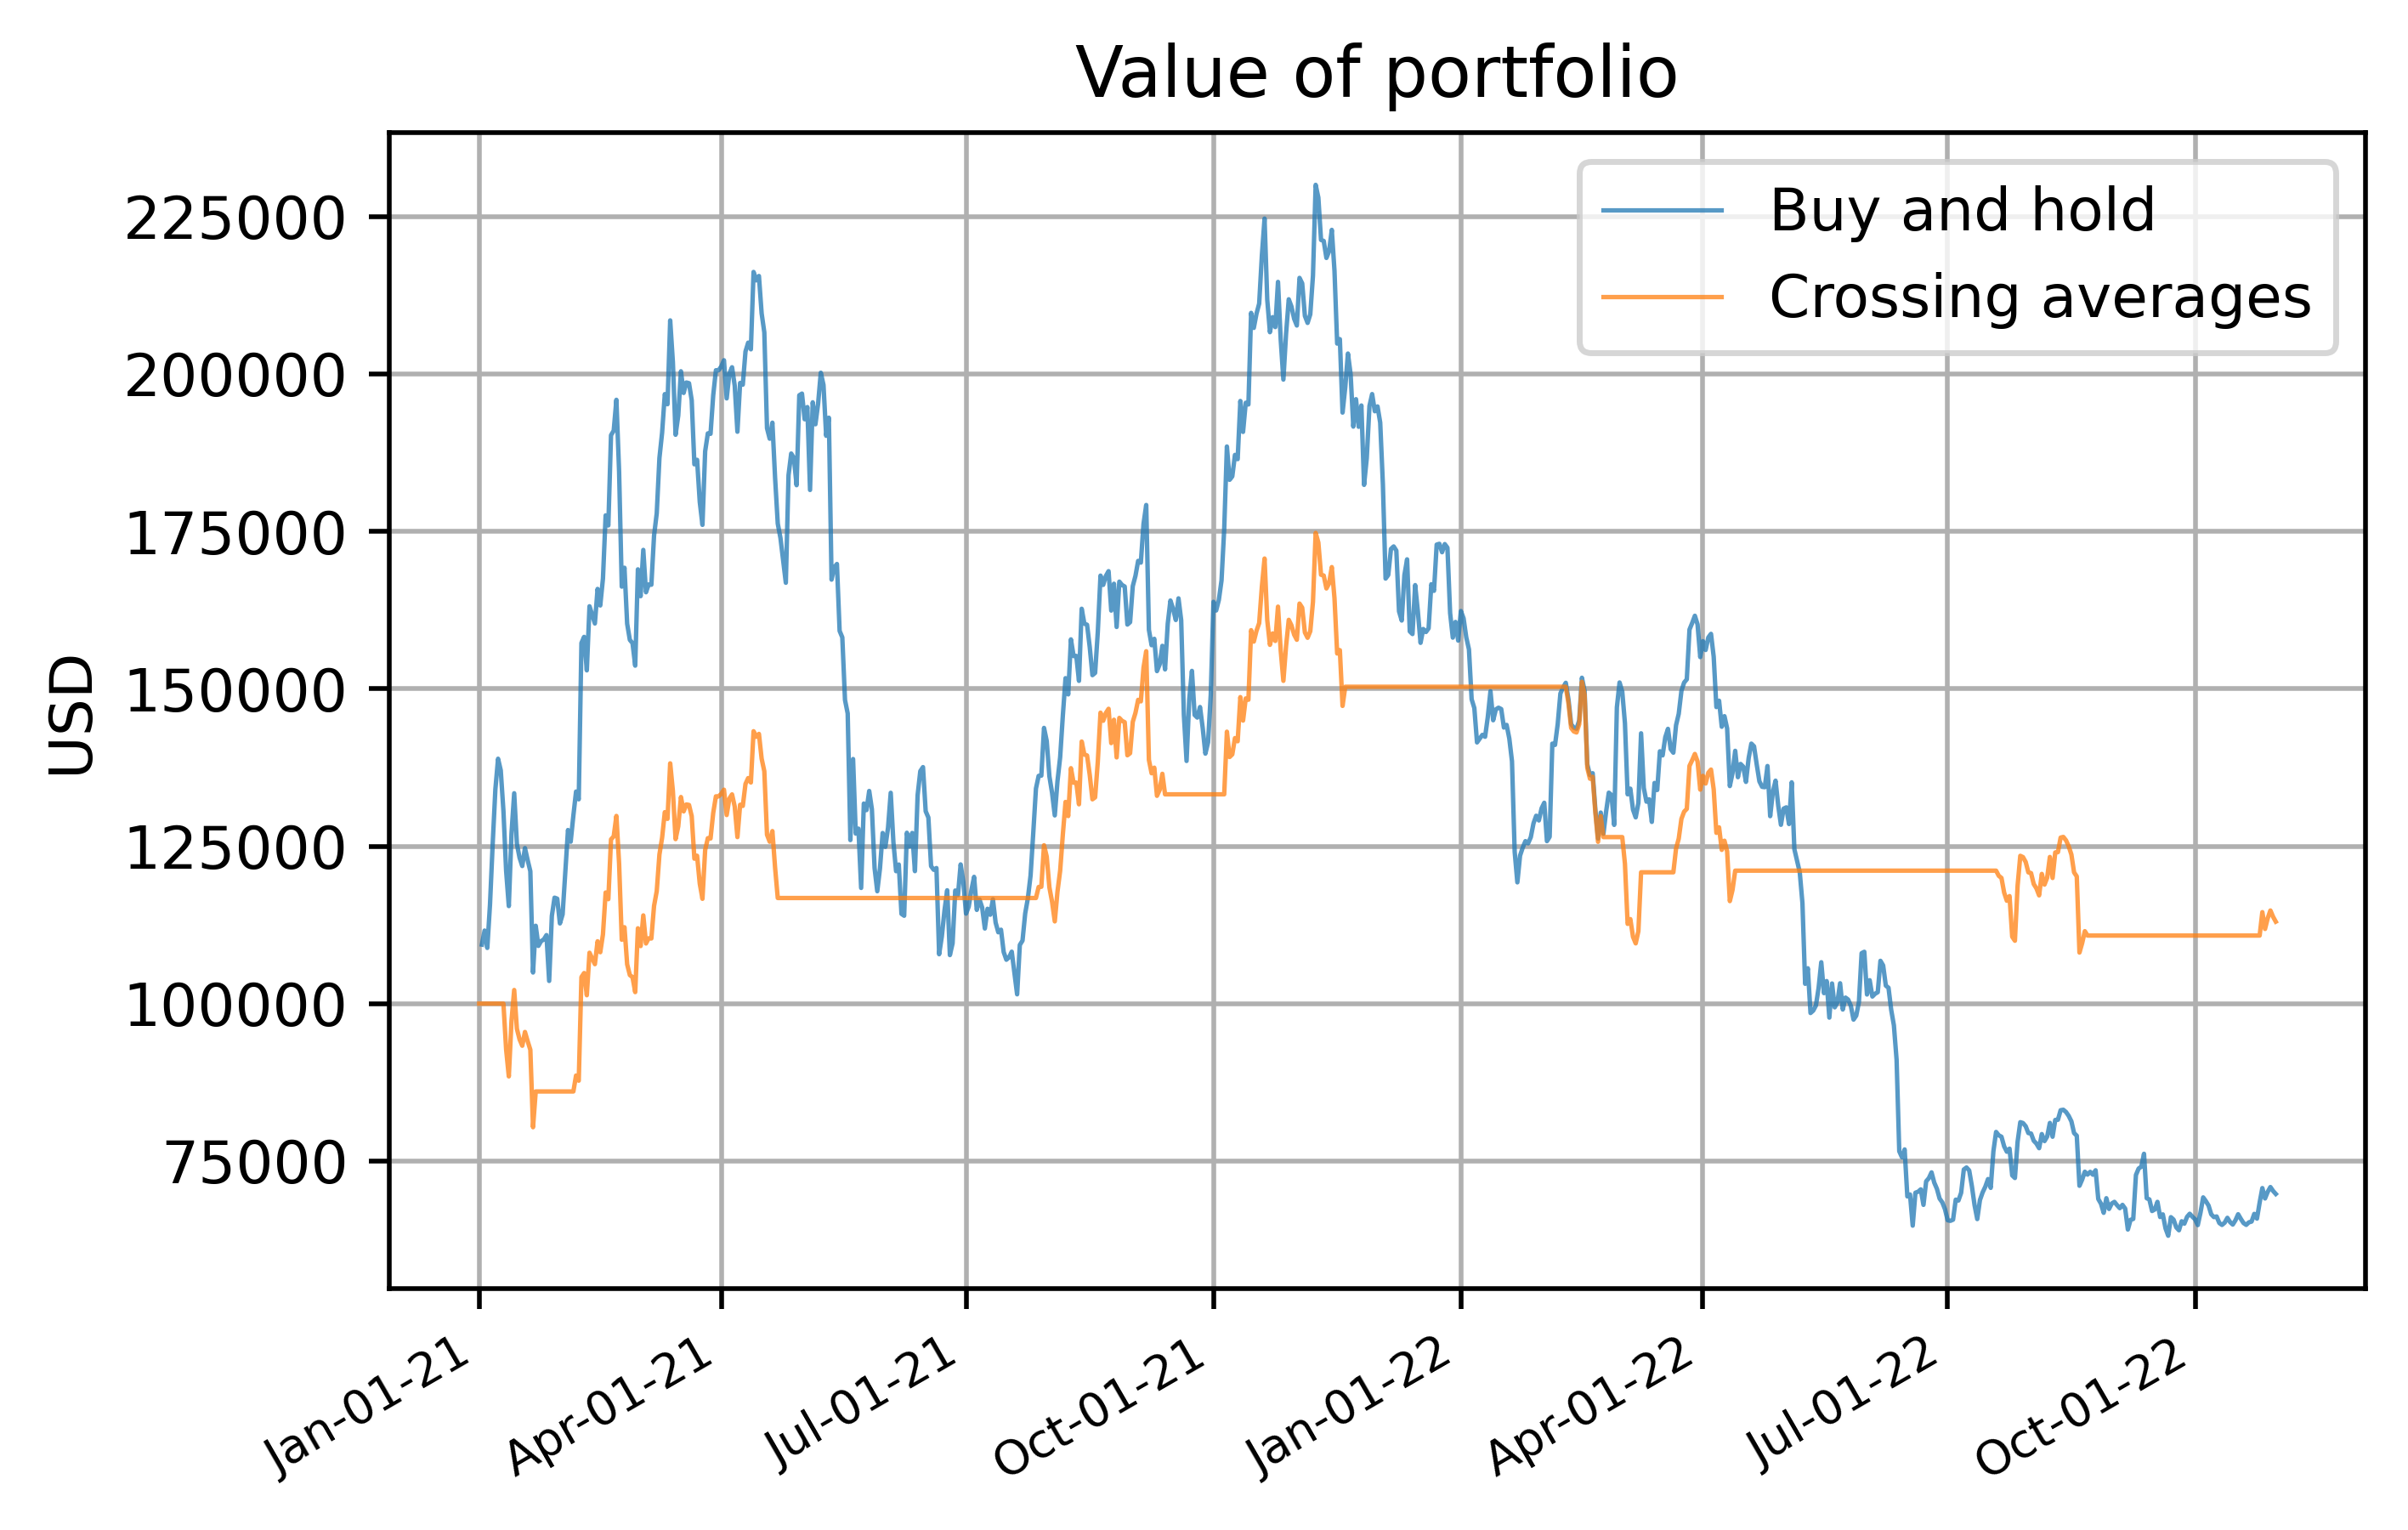

In [20]:
fig, ax = plt.subplots(dpi=500)

# format the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis="x", labelsize=8)
fig.autofmt_xdate()

# plotting the value of the buy and hold strategy
ax.plot(initial_balance*backtest.BTC_Return.cumprod(), lw=0.75, alpha=0.75, label="Buy and hold")

# using the crossover startegy
ax.plot(backtest["Balance"], lw=0.75, alpha=0.75, label="Crossing averages")

# add labels and title
ax.set_ylabel("USD")
ax.set_title("Value of portfolio")
ax.grid()
ax.legend()

# show plot
plt.show()